In [1]:
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate
from scipy import stats
from fbprophet import Prophet
%matplotlib inline

## 1. Faça uma descrição dos dados de acordo com análises que julgar relevantes, por exemplo: estatística descritiva, análise de sazonalidade, etc. Essas análises devem conter gráficos, visualizações e explicações.

In [2]:
df = pd.read_csv('serie_vendas.csv')

## Checking the data

In [3]:
df.head()

,id_produto,data_referencia,valor,qtd_vendida,qtd_estoque
0,2,2016-01-07,12.59,21.0,NaN
1,2,2016-01-08,12.59,31.0,NaN
2,2,2016-01-09,12.59,21.0,NaN
3,2,2016-01-10,12.59,34.0,NaN
4,2,2016-01-11,12.59,29.0,NaN


In [4]:
df.columns

Index(['id_produto', 'data_referencia', 'valor', 'qtd_vendida', 'qtd_estoque'], dtype='object')

In [5]:
df.dtypes

id_produto           int64
data_referencia     object
valor              float64
qtd_vendida        float64
qtd_estoque        float64
dtype: object

In [6]:
### Converting the data_referencia column to datetime format

In [7]:
df['data_referencia'] = pd.to_datetime(df["data_referencia"], format="%Y-%m-%d")
df['year'] = df['data_referencia'].dt.year
df['month'] = df['data_referencia'].dt.month
df['day'] = df['data_referencia'].dt.day

In [8]:
df.head()

,id_produto,data_referencia,valor,qtd_vendida,qtd_estoque,year,month,day
0,2,2016-01-07,12.59,21.0,NaN,2016,1,7
1,2,2016-01-08,12.59,31.0,NaN,2016,1,8
2,2,2016-01-09,12.59,21.0,NaN,2016,1,9
3,2,2016-01-10,12.59,34.0,NaN,2016,1,10
4,2,2016-01-11,12.59,29.0,NaN,2016,1,11


In [9]:
df.shape

(48632, 8)

In [10]:
## Check if there is missing values
na = df.isna().sum()
na[na >0]

valor          22605
qtd_vendida    22605
qtd_estoque      685
dtype: int64

In [11]:
## One interesting aspect is the missing values in the column valor.
## This is not expected let's check why this is happening

In [12]:
na_valor = df[df['valor'].isna()]

# Mock filling to groupby
na_valor = na_valor.fillna('null')

In [13]:
na_valor.groupby(['valor', 'qtd_vendida']).size()

valor  qtd_vendida
null   null           22605
dtype: int64

In [14]:
na_valor.groupby(['valor', 'qtd_vendida', 'qtd_estoque']).size().head()

valor  qtd_vendida  qtd_estoque
null   null         0.00           8623
                    0.01              8
                    0.02              2
                    0.03             16
                    0.04              2
dtype: int64

In [15]:
## Every time the valor row is NaN the corresponding qtd_vendida is also NaN
## the same doesn't occur with the qtd_estoque column

In [16]:
na_qtd_vendida = df[df['qtd_vendida'].isna()]

# Mock filling to groupby
na_qtd_vendida = na_qtd_vendida.fillna('null')

In [17]:
na_qtd_vendida.groupby(['valor', 'qtd_vendida']).size()

valor  qtd_vendida
null   null           22605
dtype: int64

In [18]:
## As expected every time the qtd_vendida is empty the corresponding valor is also empty
## It was expected since the number of NaN in the valor column is the same as qtd_vendida column

In [19]:
# Let's check if the product price change over time

In [20]:
grouped = df.groupby(['id_produto', 'valor']).valor.nunique().to_frame()

In [21]:
grouped[grouped['valor'] > 1]

,,valor
id_produto,valor,


In [22]:
# The product price doesn't change over time therefore we can propagate the price to all missing products

In [23]:
map_values = {k:v for k,v in df.dropna().drop_duplicates('id_produto')[['id_produto', 'valor']].values}

In [24]:
df['valor_corrigido'] = df.id_produto.map(map_values)

In [25]:
df[df['valor_corrigido'].isna()].id_produto.unique()

array([ 68,  70,  74, 147, 156])

In [26]:
## Even after this propagation some products still do not present a real value

In [27]:
missing_valor = df[df.id_produto.isin(df[df['valor_corrigido'].isna()].id_produto.unique())]

In [28]:
print(missing_valor['valor'].unique())
print(missing_valor['qtd_estoque'].unique())
print(missing_valor['qtd_vendida'].unique())

[nan]
[0. 1.]
[nan]


In [29]:
product_68 = missing_valor[missing_valor.id_produto.isin(missing_valor[missing_valor['qtd_estoque'] == 1].id_produto.unique())]


In [30]:
product_68.loc[product_68[product_68['qtd_estoque'] == 1].index[0] - 5: product_68[product_68['qtd_estoque'] == 1].index[-1] +5, :]

,id_produto,data_referencia,valor,qtd_vendida,qtd_estoque,year,month,day,valor_corrigido
26850,68,2016-09-15,NaN,NaN,0.0,2016,9,15,NaN
26851,68,2016-09-16,NaN,NaN,0.0,2016,9,16,NaN
26852,68,2016-09-17,NaN,NaN,0.0,2016,9,17,NaN
26853,68,2016-09-18,NaN,NaN,0.0,2016,9,18,NaN
26854,68,2016-09-19,NaN,NaN,0.0,2016,9,19,NaN
26855,68,2016-09-20,NaN,NaN,1.0,2016,9,20,NaN
26856,68,2016-09-21,NaN,NaN,1.0,2016,9,21,NaN
26857,68,2016-09-22,NaN,NaN,1.0,2016,9,22,NaN
26858,68,2016-09-23,NaN,NaN,1.0,2016,9,23,NaN
26859,68,2016-09-24,NaN,NaN,1.0,2016,9,24,NaN


In [31]:
## Between all products missing the value in columns valor and qtd_vendida, only one had a short time of shelf-life
## The product ID 68 stayed on stock during 2016-09-19 to 2016-09-29

In [32]:
missing_valor.groupby('id_produto').agg({'data_referencia': ['min', 'max']})

data_referencia           
                       min        max
id_produto                           
68              2016-03-10 2017-08-23
70              2016-03-10 2017-12-29
74              2016-03-10 2017-08-23
147             2017-11-29 2017-12-29
156             2016-03-10 2017-08-23

In [33]:
print(df[~df['id_produto'].isin(missing_valor.id_produto)].groupby('id_produto').agg({'data_referencia': ['min', 'max']})['data_referencia']['max'].max())
print(df[~df['id_produto'].isin(missing_valor.id_produto)].groupby('id_produto').agg({'data_referencia': ['min', 'max']})['data_referencia']['min'].min())

2017-12-29 00:00:00
2016-01-07 00:00:00


In [34]:
# One product ID: 147 was recently inserted 2017-11-29 and last updated 2017-12-29
# probably there was no sufficient time to buy/sell this product yet, requiring more time to understand why this anomality occurred

In [35]:
df.id_produto.nunique()

78

In [36]:
df[df['valor_corrigido'].isna()].id_produto.nunique()

5

In [37]:
# There are 78 SKU in total, but 3 of them do not have enough information to understand why those anomalities (missing value) occurred
# probably those products (70, 74, 156) were discontinued
# One of them (68) was available during a short period of time but it wasn't sold.
# The last one (147) is a new product requiring more time to understand the sales profile

In [38]:
grouped_year_month = df.groupby(['year','month']).qtd_vendida.sum().reset_index()

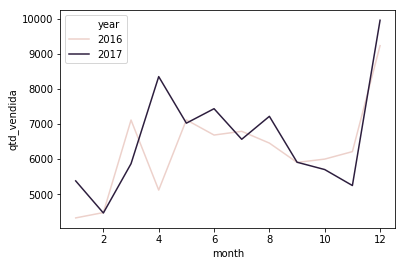

In [39]:
sns.lineplot(y = grouped_year_month.qtd_vendida,
             x = grouped_year_month.month,
            hue = 'year',
            data = grouped_year_month)

**The SKUs showed higher sales during the months of March/April and December**

In [40]:
df['profit'] = df['valor_corrigido'] * df['qtd_vendida']

In [41]:
vendas_por_produto = df.groupby(['id_produto']).qtd_vendida.sum().sort_values(ascending = False)

In [42]:
vendas_por_produto_rank = vendas_por_produto.reset_index()

In [43]:
vendas_por_produto_rank['rank'] = [x+1 for x in range(vendas_por_produto_rank.shape[0])]

In [44]:
group_top_profit = df.groupby('id_produto').profit.sum().sort_values(ascending = False).head(10).to_frame().reset_index().merge(vendas_por_produto_rank).reset_index()

In [45]:
group_top_profit

,index,id_produto,profit,qtd_vendida,rank
0,0,13,349381.5000,12350.00,3
1,1,2,265787.4900,21111.00,1
2,2,50,251879.5968,628.16,40
3,3,10,249308.1000,6310.00,7
4,4,9,228082.4500,10391.00,4
5,5,3,206415.3000,2730.00,15
6,6,4,135414.1800,4023.00,11
7,7,27,99095.0400,2944.00,14
8,8,65,91713.2400,2238.00,16
9,9,26,82075.1303,365.77,54


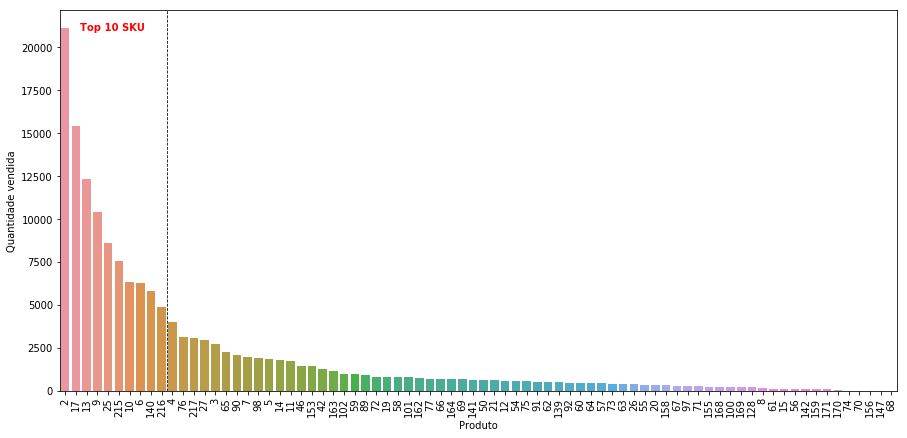

In [46]:

fig, ax = plt.subplots(figsize = (15,7))
ax = sns.barplot(x = vendas_por_produto.index,
            y = vendas_por_produto,
           order = vendas_por_produto.index)
plt.xlabel('Produto')
plt.ylabel('Quantidade vendida')
plt.setp(ax.get_xticklabels(), rotation=90 )
plt.axvline(9.5, linestyle = '--', color = 'black', linewidth = 0.8)
plt.text(x = 1.4, y =21000, s = 'Top 10 SKU',weight="bold", color = 'Red')
plt.show()

**Analysing the top 10 profitable SKU, only 4 of them were the top 10 in term of unit sales volume (13, 2, 10, 9).**  
**The SKU 26 for example is the SKU with rank 54 in sales performance but showed a profit of $82075.13, and the most profitable SKU (product ID 13) showed a sale rank of 3 (the third in sale volume)**

In [48]:
model = Prophet()

forecast_df = df[['data_referencia', 'qtd_vendida']]
forecast_df.columns = ['ds', 'y']
model.fit(forecast_df)
forecast = model.predict(forecast_df)



INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


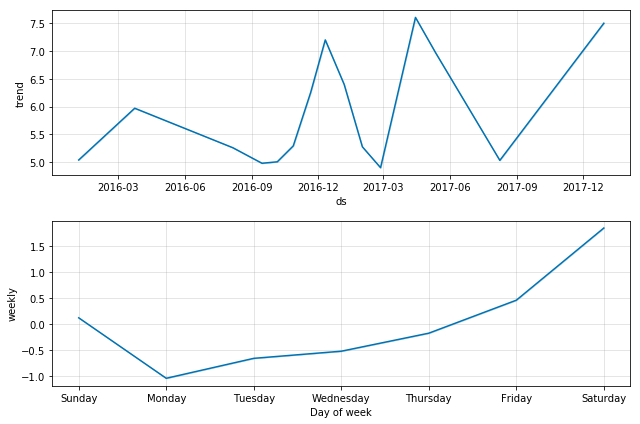

In [49]:
plot = model.plot_components(forecast)

**Curiously, analysing the seasonality it was possible to identify a higher sales during the end of the week (Thrusday to Saturday) and a reduction of the sales force from Sunday to Wednesday**

In [50]:
values = df[df['valor_corrigido']> 0]['valor_corrigido'].unique()
print(f'Mean SKU value: {values.mean():.2f}')

Mean SKU value: 73.55


## 2. Qual o tipo de produto que você imagina que vende nessa loja? Justifique sua resposta.

**Based on the seasonality of the sales with a peak during March/April and December, with the higher sales during the end of the week (Thursday to Saturday) in combination with some SKU with short expiring date and low price, suggests this store sells some product related to food, like a restaurant.**

## 3. Liste os 10 SKUs que tiveram as maiores vendas no segundo semestre de 2017

In [51]:
top_SKU_2017 = df[df['data_referencia'] >= '2017-07-01'].groupby("id_produto")["qtd_vendida"].sum().sort_values(ascending=False)

In [52]:
top_SKU_2017 = df[df['data_referencia'] >= '2017-07-01'].groupby(
                                                'id_produto'
                                                ).agg(
                                                    {'qtd_vendida': 'sum', 'valor_corrigido': 'mean'}
                                                      ).sort_values(
                                                            'qtd_vendida', ascending = False
                                                                    )

In [53]:
top_SKU_2017.columns = ['Quantidade vendida', 'Preço']
top_SKU_2017.index.names = ['ID']

In [54]:
print(tabulate(top_SKU_2017.head(10), headers='keys', tablefmt='psql'))

+------+----------------------+---------+
|   ID |   Quantidade vendida |   Preço |
|------+----------------------+---------|
|    2 |                 4837 |   12.59 |
|   17 |                 4148 |    3.9  |
|   13 |                 3386 |   28.29 |
|  140 |                 3294 |    6.83 |
|    9 |                 2731 |   21.95 |
|  215 |                 2226 |    0.5  |
|   25 |                 1937 |    6.15 |
|   10 |                 1680 |   39.51 |
|    6 |                 1541 |   12.59 |
|  216 |                 1231 |    0.5  |
+------+----------------------+---------+


## 4. Verifique a consistência entre a venda e o estoque do SKU que apresentou a maior venda no segundo semestre de 2017.

**The SKU with the highest sale was the product 2.**

In [55]:
# Filtering by product 2
product2 = df[df['id_produto'] == 2]

In [56]:

product2.head(10)

,id_produto,data_referencia,valor,qtd_vendida,qtd_estoque,year,month,day,valor_corrigido,profit
0,2,2016-01-07,12.59,21.0,NaN,2016,1,7,12.59,264.39
1,2,2016-01-08,12.59,31.0,NaN,2016,1,8,12.59,390.29
2,2,2016-01-09,12.59,21.0,NaN,2016,1,9,12.59,264.39
3,2,2016-01-10,12.59,34.0,NaN,2016,1,10,12.59,428.06
4,2,2016-01-11,12.59,29.0,NaN,2016,1,11,12.59,365.11
5,2,2016-01-12,12.59,26.0,NaN,2016,1,12,12.59,327.34
6,2,2016-01-13,12.59,17.0,NaN,2016,1,13,12.59,214.03
7,2,2016-01-14,12.59,25.0,NaN,2016,1,14,12.59,314.75
8,2,2016-01-15,12.59,33.0,NaN,2016,1,15,12.59,415.47
9,2,2016-01-16,12.59,48.0,984.0,2016,1,16,12.59,604.32


In [57]:
# missing values in qtd_estoque
product2.isna().sum()

id_produto          0
data_referencia     0
valor              13
qtd_vendida        13
qtd_estoque        20
year                0
month               0
day                 0
valor_corrigido     0
profit             13
dtype: int64

**There are missing values in qtd_estoque, after checking the qtd_estoque is unlikely the value is 0.  
Therefore, I decided to fill those missing values with the sum of sales plus the current qtd_estoque value**  
**for example:**

|  index  |   id_produto | data_referencia     |   valor |   qtd_vendida |   qtd_estoque | 
|---------|--------------|---------------------|---------|----------------|---------------|
|  8 |            2 | 2016-01-15|   12.59 |            33 |           nan |
|  9 |            2 | 2016-01-16|   12.59 |            48 |           984 |

Here I filled the qtd_estoque column of row 8 with the sum of qtd_estoque plus qtd_vendida of row 9 (48+984).

In [58]:
while product2.qtd_estoque.isnull().values.any():
    product2['qtd_estoque'] = np.where(product2.qtd_estoque.isna(),
                                       product2.shift(-1).qtd_estoque + product2.shift(-1).qtd_vendida,
                                       product2.qtd_estoque)

/home/linuxbrew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [59]:
# missing values in qtd_estoque
product2.isna().sum()

id_produto          0
data_referencia     0
valor              13
qtd_vendida        13
qtd_estoque         0
year                0
month               0
day                 0
valor_corrigido     0
profit             13
dtype: int64

In [60]:
product2[product2['qtd_vendida'].isna()]

,id_produto,data_referencia,valor,qtd_vendida,qtd_estoque,year,month,day,valor_corrigido,profit
67,2,2016-03-14,NaN,NaN,0.0,2016,3,14,12.59,NaN
68,2,2016-03-15,NaN,NaN,0.0,2016,3,15,12.59,NaN
95,2,2016-04-11,NaN,NaN,0.0,2016,4,11,12.59,NaN
200,2,2016-07-25,NaN,NaN,0.0,2016,7,25,12.59,NaN
342,2,2016-12-14,NaN,NaN,0.0,2016,12,14,12.59,NaN
400,2,2017-02-12,NaN,NaN,1.0,2017,2,12,12.59,NaN
401,2,2017-02-13,NaN,NaN,1.0,2017,2,13,12.59,NaN
548,2,2017-07-10,NaN,NaN,1.0,2017,7,10,12.59,NaN
559,2,2017-07-21,NaN,NaN,0.0,2017,7,21,12.59,NaN
560,2,2017-07-22,NaN,NaN,0.0,2017,7,22,12.59,NaN


In [61]:
# Filling missing values on qtd_vendida column with 0
product2 = product2.fillna(0)

**Checking the available stock and the sales performance**

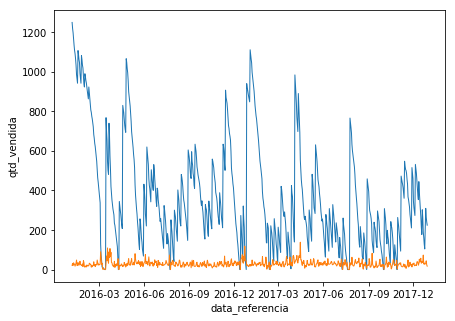

In [62]:
fig, ax = plt.subplots(1,1 , figsize = (7,5))
ax = sns.lineplot(x = 'data_referencia',
            y = 'qtd_estoque',
            estimator = None, lw = 1,
            data = product2, ax = ax)

ax = sns.lineplot(x = 'data_referencia',
            y = 'qtd_vendida',
            estimator = None, lw = 1,
            data = product2, ax = ax)



/home/linuxbrew/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



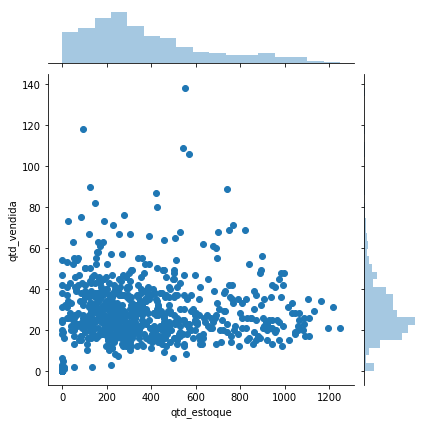

In [63]:
g = sns.jointplot(x = 'qtd_estoque',
            y = 'qtd_vendida',
               data = product2)
plt.show()

**Using both graphs, I observed a drastic several drops in the stock but it is not followed by the same sales volume**  
**Indicating that although the product 2 shows the highest sales performance as compared to the other products,  
several units are not being saled, therefore the supply-chain is not optimized.**

In [64]:
product2.describe()

,id_produto,valor,qtd_vendida,qtd_estoque,year,month,day,valor_corrigido,profit
count,720.0,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,7.200000e+02,720.000000
mean,2.0,12.362681,29.320833,375.408333,2016.501389,6.543056,15.794444,1.259000e+01,369.149292
std,0.0,1.677554,15.555584,276.202577,0.500346,3.410828,8.739435,1.031003e-13,195.844805
min,2.0,0.000000,0.000000,0.000000,2016.000000,1.000000,1.000000,1.259000e+01,0.000000
25%,2.0,12.590000,20.000000,171.000000,2016.000000,4.000000,8.000000,1.259000e+01,251.800000
50%,2.0,12.590000,26.000000,300.500000,2017.000000,7.000000,16.000000,1.259000e+01,327.340000
75%,2.0,12.590000,37.000000,507.000000,2017.000000,9.250000,23.000000,1.259000e+01,465.830000
max,2.0,12.590000,138.000000,1248.000000,2017.000000,12.000000,31.000000,1.259000e+01,1737.420000


**Here we can observed that the mean sales of product2 is 29 while the mean stock (MOH) is 276, 
indicating that the overall stock is enough for 10 months.  
Although it is not true, since the above graph indicates a gamma distribution.  
Let's check if the qtd_vendida of product 2 follows a gamma distribution.**

In [65]:
from scipy import stats

In [66]:
# Fitting data in a gamma distribution
ag,bg,cg = stats.gamma.fit(product2['qtd_vendida']) 

In [67]:
lnspc = np.linspace(product2['qtd_vendida'].min(), product2['qtd_vendida'].max(), product2['qtd_vendida'].shape[0])

In [68]:
# The PDF
pdf_gamma = stats.gamma.pdf(lnspc, ag, bg,cg)  

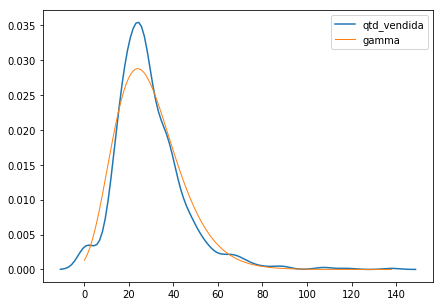

In [69]:
fig, ax = plt.subplots(1,1 , figsize = (7,5))
ax = sns.kdeplot(
            product2['qtd_vendida'],
            ax = ax)
ax = sns.lineplot(x = lnspc,
            y = pdf_gamma,
            estimator = None, lw = 1,ax = ax, label = 'gamma')

**As expected, the sales of product2 follows a gamma distribution**

In [70]:
stats.gamma.ppf( [0.01, 0.5,0.99, 0.999], ag, bg,cg) 

array([ 3.10863046, 27.55146815, 71.07506349, 90.14823137])

In [71]:
product2[product2['qtd_vendida'] > 90]

,id_produto,data_referencia,valor,qtd_vendida,qtd_estoque,year,month,day,valor_corrigido,profit
72,2,2016-03-19,12.59,109.0,545.0,2016,3,19,12.59,1372.31
77,2,2016-03-24,12.59,106.0,572.0,2016,3,24,12.59,1334.54
351,2,2016-12-23,12.59,118.0,93.0,2016,12,23,12.59,1485.62
462,2,2017-04-15,12.59,138.0,553.0,2017,4,15,12.59,1737.42


**Here we can observe that with a stock of 90 products there's a 99.9% probability to be safe, delivering enough products to the client**  
**Analysing our data only four months were outliers, mainly at March and December where the sales were higher. This profile was expected since the sales were higher during December and March/April**

**Checking if there are expiring SKU**

In [72]:
product2['diff'] = product2['qtd_estoque'] - product2['qtd_vendida']

In [73]:
product2['expired'] = product2.shift()['qtd_estoque'] - (product2.qtd_estoque + product2['qtd_vendida'])

In [74]:
product2

,id_produto,data_referencia,valor,qtd_vendida,qtd_estoque,year,month,day,valor_corrigido,profit,diff,expired
0,2,2016-01-07,12.59,21.0,1248.0,2016,1,7,12.59,264.39,1227.0,NaN
1,2,2016-01-08,12.59,31.0,1217.0,2016,1,8,12.59,390.29,1186.0,0.0
2,2,2016-01-09,12.59,21.0,1196.0,2016,1,9,12.59,264.39,1175.0,0.0
3,2,2016-01-10,12.59,34.0,1162.0,2016,1,10,12.59,428.06,1128.0,0.0
4,2,2016-01-11,12.59,29.0,1133.0,2016,1,11,12.59,365.11,1104.0,0.0
5,2,2016-01-12,12.59,26.0,1107.0,2016,1,12,12.59,327.34,1081.0,0.0
6,2,2016-01-13,12.59,17.0,1090.0,2016,1,13,12.59,214.03,1073.0,0.0
7,2,2016-01-14,12.59,25.0,1065.0,2016,1,14,12.59,314.75,1040.0,0.0
8,2,2016-01-15,12.59,33.0,1032.0,2016,1,15,12.59,415.47,999.0,0.0
9,2,2016-01-16,12.59,48.0,984.0,2016,1,16,12.59,604.32,936.0,0.0


In [75]:
profit = product2['qtd_vendida'].sum()* 12.59

In [76]:
# Number of expired products
product2[product2['expired']>0]['expired'].sum()

846.0

In [77]:
product2[product2['qtd_estoque'] == 0].shape[0] /product2.shape[0] * 100 

2.5

In [78]:
product2[product2['qtd_estoque'] == 0].shape[0]

18

In [79]:
product2[product2['qtd_estoque'] == 0]

,id_produto,data_referencia,valor,qtd_vendida,qtd_estoque,year,month,day,valor_corrigido,profit,diff,expired
66,2,2016-03-13,12.59,2.0,0.0,2016,3,13,12.59,25.18,-2.0,0.0
67,2,2016-03-14,0.00,0.0,0.0,2016,3,14,12.59,0.00,0.0,0.0
68,2,2016-03-15,0.00,0.0,0.0,2016,3,15,12.59,0.00,0.0,0.0
94,2,2016-04-10,12.59,54.0,0.0,2016,4,10,12.59,679.86,-54.0,0.0
95,2,2016-04-11,0.00,0.0,0.0,2016,4,11,12.59,0.00,0.0,0.0
199,2,2016-07-24,12.59,31.0,0.0,2016,7,24,12.59,390.29,-31.0,-2.0
200,2,2016-07-25,0.00,0.0,0.0,2016,7,25,12.59,0.00,0.0,0.0
341,2,2016-12-13,12.59,24.0,0.0,2016,12,13,12.59,302.16,-24.0,0.0
342,2,2016-12-14,0.00,0.0,0.0,2016,12,14,12.59,0.00,0.0,0.0
353,2,2016-12-26,12.59,42.0,0.0,2016,12,26,12.59,528.78,-42.0,8.0


In [80]:
product2.shape[0]

720

**2.5% of the time the SKU 2 stayed in backorder this correspond to 18 day out of 720 days.**

In [81]:
product2[product2['expired']>0]['expired'].sum()*12.59

10651.14

**Also the incorrect supply chain managment resulted in a loss of $10,651.14 during the analysed timeline**

### Final considerations

The SKU 2 represented the highest sale rate during the last semester of 2017.

Although this SKU is the best seller, the low associated value ($12.59) resulted in this SKU being the second in profit. The highest profit was achieved by the third SKU (SKU 13), when analyzing the sales performance).

There was a high inconsistency between the qtd_estoque, with some missing values, to fix that I inputted the data based on the procedure mentioned above. The columns qtd_vendida and valor also showed some inconsistency, but since the value of SKU 2 did not change during the period I assumed the missing value for valor was the same and the qtd_vendida was 0.

Analyzing the qtd_vendida and qtd_estoque, we can see a huge stock of this SKU, but the sales did not follow the same pattern. This may lead to high cost associated to this SKU not only because of the expiring products, but also related to the storage cost itself. A better supply chain management could increase the profit of this SKU. Observing the sales performance, we observed a gamma distribution, in which there is a 99.9% probability of selling less than 90 units of this product per day. Further analyses are required since there is also an increased sale during December and March/April months.

Taking the stock and selling data into consideration, we observed that SKU 2 remained on backorder during 18 days out of 720 day period. This represents 2.5% of the total days analyzed, in which 8 of them occurred during high SKU demand periods (March, April, December). Nevertheless, a better forecasting of this SKU is required.


### 5. Construa um modelo genérico de previsão de vendas de um SKU. Na entrada do modelo podem ser colocadas quaisquer variáveis, e a saída do modelo deve ser a previsão do volume total de vendas de um determinado SKU por dia.

### Forecast analysis using SKU 2.
**Here I used facebook framework Phophet.**  
From facebook prohphet page.  
"Producing high quality forecasts is not an easy problem for either machines or for most analysts.  
We have observed two main themes in the practice of creating a variety of business forecasts:

    -Completely automatic forecasting techniques can be brittle and they are often too inflexible to incorporate 
    useful assumptions or heuristics.
    -Analysts who can product high quality forecasts are quite rare because forecasting is a specialized 
    data science skill requiring substantial experience. ”

In [82]:
from fbprophet import Prophet

In [83]:
forecast_df = product2[['data_referencia', 'qtd_vendida']]


In [89]:
forecast_df = product2[['data_referencia', 'qtd_vendida']]
forecast_df.columns = ['ds', 'y']
n_tests = 60
df_train = forecast_df[:-n_tests]
df_test = forecast_df[-n_tests:]


In [90]:

model = Prophet(changepoint_prior_scale=0.9, n_changepoints = 5, yearly_seasonality = True, uncertainty_samples = 10000,
               changepoints=['2016-03-01', '2016-12-01', '2017-04-01'])

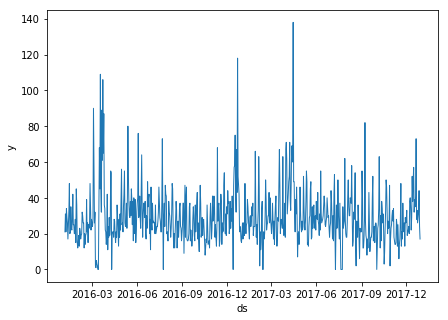

In [91]:
fig, ax = plt.subplots(1,1 , figsize = (7,5))
ax = sns.lineplot(x = 'ds',
            y = 'y',
            estimator = None, lw = 1,
            data = forecast_df, ax = ax)


Text(0,0.5,'Sales')

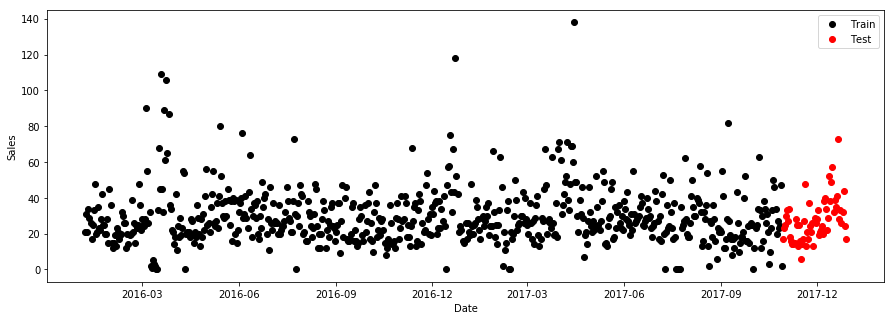

In [92]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(df_train['ds'], df_train['y'], linestyle='None', marker='o', color='black', label='Train')
ax.plot(df_test['ds'], df_test['y'], linestyle='None', marker='o', color='red', label='Test')
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Sales')

In [93]:
model = Prophet(changepoint_prior_scale=0.9, n_changepoints = 5, yearly_seasonality = True, uncertainty_samples = 10000,
               changepoints=['2016-03-01', '2016-12-01', '2017-04-01'])

In [94]:
model.fit(df_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [95]:
future = model.make_future_dataframe(periods=50)

In [96]:
forecast = model.predict(forecast_df)

In [97]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-01-07,28.906167,8.192105,41.569118,28.906167,28.906167,-4.124217,-4.124217,-4.124217,-2.437258,-2.437258,-2.437258,-1.686959,-1.686959,-1.686959,0.0,0.0,0.0,24.781951
1,2016-01-08,28.909948,13.671199,46.215193,28.909948,28.909948,1.133362,1.133362,1.133362,3.400413,3.400413,3.400413,-2.267051,-2.267051,-2.267051,0.0,0.0,0.0,30.043309
2,2016-01-09,28.913728,26.421280,58.813567,28.913728,28.913728,13.885506,13.885506,13.885506,16.636150,16.636150,16.636150,-2.750643,-2.750643,-2.750643,0.0,0.0,0.0,42.799234
3,2016-01-10,28.917508,11.411634,44.038374,28.917508,28.917508,-1.012565,-1.012565,-1.012565,2.124729,2.124729,2.124729,-3.137294,-3.137294,-3.137294,0.0,0.0,0.0,27.904943
4,2016-01-11,28.921288,0.173982,32.835330,28.921288,28.921288,-12.492748,-12.492748,-12.492748,-9.063770,-9.063770,-9.063770,-3.428977,-3.428977,-3.428977,0.0,0.0,0.0,16.428541


Text(0,0.5,'Sales')

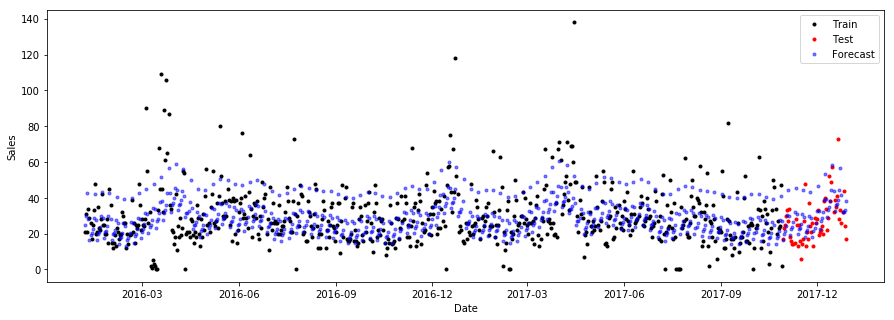

In [98]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(df_train['ds'], df_train['y'], c='black', marker='o', ms=3, linestyle='None', label='Train')
ax.plot(df_test['ds'], df_test['y'], c='r', marker='o', ms=3, linestyle='None', label='Test')
ax.plot(forecast['ds'], forecast['yhat'], c='b', marker='o', ms=3, linestyle='None', label='Forecast', alpha=0.5)
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Sales')

**Here we can see that the trend is correcly captured by Prophet, indicating a higher sales during December**


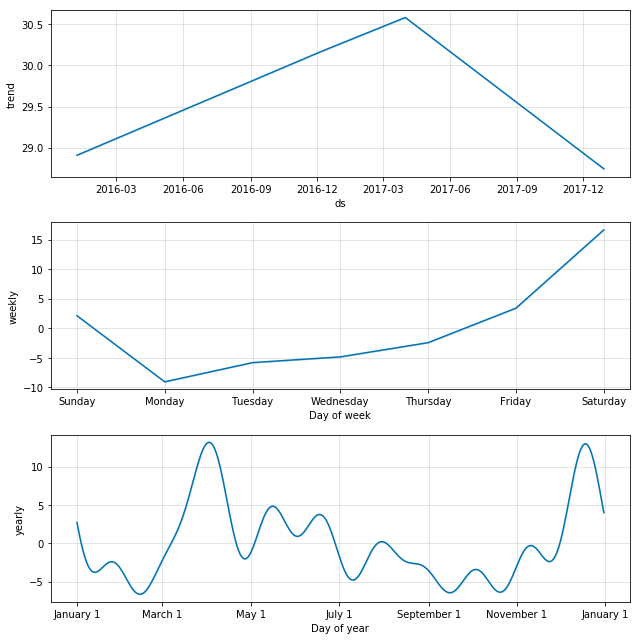

In [99]:
plot = model.plot_components(forecast)

In [100]:
y_true = df_test['y']
y_forecast = forecast[-n_tests:]['yhat']
rmse = np.sqrt(((y_forecast - y_true)**2).mean())
print('The RMSE is:', rmse)

The RMSE is: 12.110393361363908


In [101]:
import pickle

## Pickled this model to use it later
pkl_path = "sku2.forecasting.Prophet.pkl"
with open(pkl_path, "wb") as f:
    pickle.dump(model, f)
